In [1]:
from IPython.display import Video
import gymnasium as gym
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque
import random



In [ ]:
# HYPER-PARAMETERS
GAMMA = 0.99
CLIP_EPSILON = 0.2 
MAX_STEPS = 500
EPISODES = 600 
BATCH_SIZE = 32 #number of batches to split the data
UPDATE_EPOCHS = 4 #number of times to cycle through all data



SEED = 12 
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Common initialization technique to help with stability 
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class ActorNetwork(nn.Module):
    def __init__(self, state_dim, num_actions, hidden_dim=64):
        super(ActorNetwork, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Linear(state_dim, hidden_dim)), #environment obs dimension by 64 hidden layer
            nn.Tanh(), #tanh activations
            layer_init(nn.Linear(hidden_dim, hidden_dim)), #Fully connected 64x64 hidden layers
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, num_actions)) #Output for action
        )
        
    def forward(self, state):
        logits = self.network(state)
        return logits

class CriticNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super(CriticNetwork, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Linear(state_dim, hidden_dim)), #environment obs dimension by 64 hidden layer
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),#Fully connected 64x64 hidden layers
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, 1))#Output for value estimate
        )
    def forward(self, state):
        return self.network(state).squeeze(-1)
#Same agent as in the Schulman 2017 paper
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4):
        self.actor = ActorNetwork(state_dim, action_dim).to(device)
        self.critic = CriticNetwork(state_dim).to(device) 
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr, eps=1e-5) #stepsize set
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr, eps=1e-5)

    def act(self, state, action=None):
        state = torch.FloatTensor(state).unsqueeze(0).to(device) 
        logits = self.actor(state)
        probs = Categorical(logits=logits) #applies softmax automatically
        if action is None:
            action = probs.sample()
        logprob = probs.log_prob(action) 
        entropy = probs.entropy()
        value = self.critic(state)

        return action, logprob, entropy, value 

    def update(self, states, actions, old_log_probs, returns, advantages, epsilon=0.2):

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(device)
        returns = torch.FloatTensor(returns).to(device)
        advantages = torch.FloatTensor(advantages).to(device) 
        _, log_probs, entropy, values = self.act(states,actions)
        

        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        value_loss = 0.5 * (values - returns).pow(2).mean()
        # beta=0.2 
        # Note: Originally implemented entropy loss despite it not being in the original paper
        # Many implementations use entropy loss, but it results in MUCH poorer performance in our case.
        # entropy_loss = -entropy.mean()
        # total_policy_loss = policy_loss +  beta * entropy_loss
        self.actor_optimizer.zero_grad()
        policy_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.critic_optimizer.step()
        return policy_loss.item(), value_loss.item()
def compute_returns(rewards, values, next_value, gamma=0.99):
    returns = []
    r = next_value  
    for i in reversed(range(len(rewards))):
        r = rewards[i] + gamma * r
        returns.insert(0, r)
    
    # zip for tuples 
    advantages = [ret - val for ret, val in zip(returns, values)]
    return advantages, returns

def collect_trajectory(env, agent, max_steps=700):
    # States are (max_steps) x 4 matrix containing the values of the 4 environment variables at each step
    states, actions, rewards, log_probs, values, dones = [], [], [], [], [], []
    
    state, _ = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        action, log_prob, entropy, value = agent.act(state)
        states.append(state)

        actions.append(action)
        log_probs.append(log_prob)
        values.append(value)
        
        state, reward, terminated, truncated, _ = env.step(action.item()) 
        rewards.append(reward)
        dones.append(terminated or truncated)
        total_reward += reward
        
        if terminated or truncated:
            break
    
    
    if not (terminated or truncated):
        _,_, _, final_value = agent.act(state) 
    else:
        final_value = 0.0  
    
    return states, actions, rewards, log_probs, values, dones, final_value, total_reward


env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
num_actions = env.action_space.n


agent = PPOAgent(state_dim, num_actions)

episode_rewards = []
policy_losses = []
value_losses = []
entropy_losses = []
recent_rewards = deque(maxlen=100)

print("TRAINING START")

for episode in range(EPISODES):
    states, actions, rewards, old_log_probs, values, dones, final_value, total_reward = collect_trajectory(env, agent, MAX_STEPS)
    episode_rewards.append(total_reward)
    recent_rewards.append(total_reward)

    advantages, returns = compute_returns(rewards, values, final_value, GAMMA)
    

    #normalize advantages 
    advantages = torch.FloatTensor(advantages).to(device) 
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    num_samples = len(states)
    

    indices = np.arange(num_samples)
    
    for _ in range(UPDATE_EPOCHS):
        np.random.shuffle(indices)
        
        for start in range(0, num_samples, BATCH_SIZE):
            end = min(start + BATCH_SIZE, num_samples)
            batch_indices = indices[start:end]
            
            batch_states = [states[i] for i in batch_indices]
            batch_actions = [actions[i] for i in batch_indices]
            batch_old_log_probs = [old_log_probs[i] for i in batch_indices]
            batch_returns = [returns[i] for i in batch_indices]
            batch_advantages = [advantages[i] for i in batch_indices]
            
            policy_loss, value_loss = agent.update(
                batch_states, batch_actions, batch_old_log_probs, 
                batch_returns, batch_advantages, CLIP_EPSILON
            )
            
            policy_losses.append(policy_loss)
            value_losses.append(value_loss)
    
    if episode % 50 == 0: 
        avg_reward = 0 
        if recent_rewards:
            avg_reward = np.mean(recent_rewards) 
        print(f"Episode # {episode} Moving Average Reward: {avg_reward:.2f} Episode Reward: {total_reward}")
    elif episode == EPISODES-1:
        avg_reward = 0 
        if recent_rewards:
            avg_reward = np.mean(recent_rewards) 
        print(f"Final Episode # {episode} Moving Average Reward: {avg_reward:.2f} Episode Reward: {total_reward}")


print("TRAINING END")
env.close()

TRAINING START
Episode # 0 Moving Average Reward: 18.00 Episode Reward: 18.0
Episode # 50 Moving Average Reward: 78.75 Episode Reward: 415.0
Episode # 100 Moving Average Reward: 169.89 Episode Reward: 139.0
Episode # 150 Moving Average Reward: 254.56 Episode Reward: 180.0
Episode # 200 Moving Average Reward: 240.03 Episode Reward: 500.0
Episode # 250 Moving Average Reward: 259.34 Episode Reward: 500.0
Episode # 300 Moving Average Reward: 334.85 Episode Reward: 500.0
Episode # 350 Moving Average Reward: 396.47 Episode Reward: 31.0
Episode # 400 Moving Average Reward: 409.71 Episode Reward: 500.0
Episode # 450 Moving Average Reward: 401.94 Episode Reward: 500.0
Episode # 500 Moving Average Reward: 425.91 Episode Reward: 178.0
Episode # 550 Moving Average Reward: 440.15 Episode Reward: 500.0
Final Episode # 599 Moving Average Reward: 446.68 Episode Reward: 500.0
TRAINING END


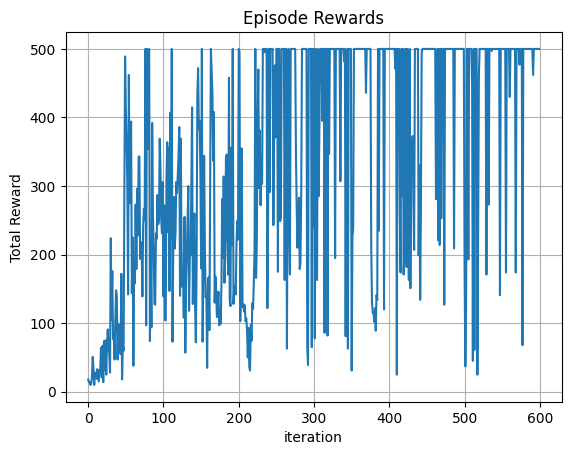

In [24]:
#Make graph of Total Rewards against iteration.

plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('iteration')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()


/var/folders/g7/r5yxt58d7_j160wrk6x0dkzm0000gn/T/ipykernel_44280/1796526220.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


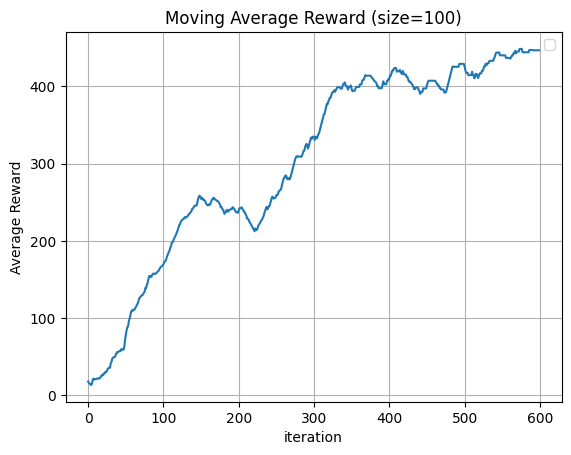

In [ ]:
moving_average = []
n = 100
for i in range(len(episode_rewards)):
    start_idx = max(0, i - n + 1)
    moving_average.append(np.mean(episode_rewards[start_idx:i+1]))
plt.plot(moving_average)
plt.title(f'Moving Average Reward (size={n})')
plt.xlabel('iteration')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)

In [26]:
def test_agent(env,agent,trials=100):
    test_rewards = []
    for _ in range(trials):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(MAX_STEPS):
            action, _, _, _ = agent.act(state) 
            state, reward, terminated, truncated, _ = env.step(action.item())
            total_reward += reward
            if terminated or truncated:
                break
        test_rewards.append(total_reward)
    return test_rewards

def test_agent_vid(agent,file_name):
    video_name = file_name + ".mp4"
    test_env = gym.make('CartPole-v1', render_mode="rgb_array")
    state, _ = test_env.reset()
    sample_frame = test_env.render()
    height, width = sample_frame.shape[:2] 
    v_writer = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    total_reward = 0

    for step in range(MAX_STEPS):
        frame = test_env.render()
        v_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

        action, _, _, _ = agent.act(state)
        state, reward, terminated, truncated, _ = test_env.step(action.item())
        total_reward += reward
        
        if terminated or truncated:
            break
    v_writer.release()
    test_env.close()
    print(f"Agent recieved reward: {total_reward} / {MAX_STEPS}.0")

In [27]:
#no training
new_agent = PPOAgent(state_dim, num_actions)
test_results= test_agent(env,new_agent)
print(test_results)
print(np.mean(test_results))

[27.0, 17.0, 11.0, 13.0, 50.0, 27.0, 15.0, 28.0, 23.0, 44.0, 26.0, 17.0, 9.0, 15.0, 15.0, 18.0, 14.0, 14.0, 35.0, 16.0, 25.0, 33.0, 32.0, 43.0, 43.0, 34.0, 47.0, 10.0, 23.0, 45.0, 16.0, 18.0, 29.0, 22.0, 19.0, 22.0, 16.0, 30.0, 12.0, 20.0, 24.0, 21.0, 21.0, 35.0, 75.0, 37.0, 55.0, 16.0, 43.0, 19.0, 19.0, 16.0, 30.0, 23.0, 12.0, 31.0, 16.0, 16.0, 25.0, 17.0, 11.0, 25.0, 16.0, 14.0, 31.0, 17.0, 24.0, 15.0, 30.0, 10.0, 25.0, 12.0, 10.0, 20.0, 10.0, 15.0, 44.0, 15.0, 25.0, 21.0, 25.0, 18.0, 9.0, 23.0, 11.0, 15.0, 17.0, 24.0, 37.0, 11.0, 61.0, 86.0, 12.0, 45.0, 21.0, 12.0, 40.0, 19.0, 14.0, 27.0]
24.41


In [ ]:
test_results = test_agent(env,agent)
print(test_results)
print(f"Average reward after 100 trials: {np.mean(test_results)}")


[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 353.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 265.0, 500.0, 500.0, 500.0, 500.0, 136.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Average reward after 1000 trials: 492.54


In [29]:
test_agent_vid(agent,'traineddemo')

Agent recieved reward: 500.0 / 500.0
